# ConvLSTM model

Import libraries and modules.

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Enable interactive widgets in Jupyter Notebook
%matplotlib widget
import torch.nn as nn
# import torch.nn.functional as F

# from numba import jit, prange
# from PIL import Image
# from sklearn.preprocessing import MinMaxScaler
# from torch.utils.data.dataset import random_split
from torchsummary import summary
from torch.utils.data import DataLoader
# from matplotlib.colors import TwoSlopeNorm#

from ConvLSTM_pytorch import *
from encode_decode_csv import decode_from_csv

Check if GPU is available.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


The following lines create variables to more easily specify what we use the model for (i.e., train and validate, test with dataset 1 and so on) in the following functions.

In [3]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

Load data from decoder.

!!! inputs and targets in train_val are stored not in the original manner. index 0 = 1, index 1 = 10, index 11 = 2, index 12 = 20 etc.

In [4]:
inputs, targets = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 3, 64, 64])
Restored targets Shape: torch.Size([80, 97, 2, 64, 64])


In [5]:
inps1, targs1 = decode_from_csv(test1)

Restored inputs Shape: torch.Size([20, 3, 64, 64])
Restored targets Shape: torch.Size([20, 97, 2, 64, 64])


In [6]:
inps2, targs2 = decode_from_csv(test2)

Restored inputs Shape: torch.Size([21, 3, 64, 64])
Restored targets Shape: torch.Size([21, 97, 2, 64, 64])


In [7]:
inps3, targs3 = decode_from_csv(test3)

Restored inputs Shape: torch.Size([10, 3, 128, 128])
Restored targets Shape: torch.Size([10, 97, 2, 128, 128])


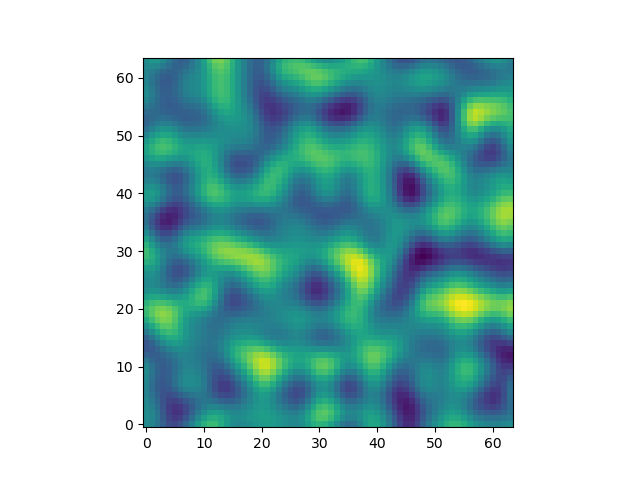

In [10]:
plt.figure()
plt.imshow(inputs[2, 0])
plt.gca().invert_yaxis() # not sure why this is needed
plt.show()

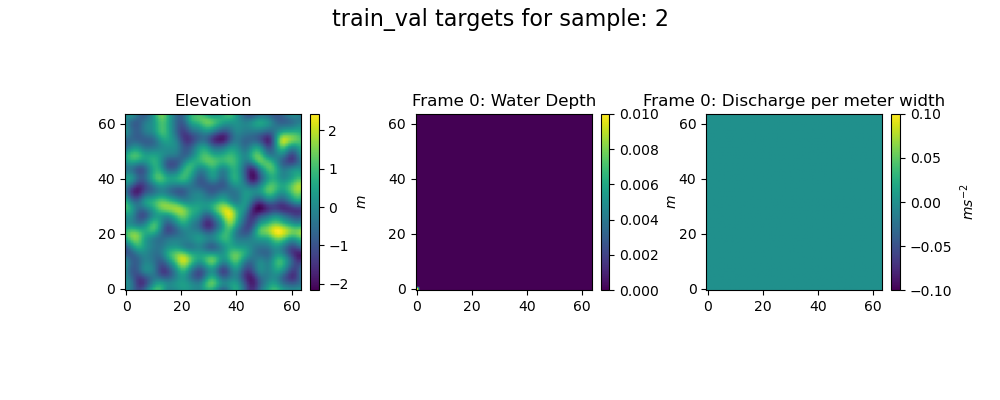

In [11]:
# change following independant variables #
target_tensor = targets
input_tensor = inputs
title_anim = train_val
sample = 2
feature1 = 0
feature2 = 1
# -------------------------------------- #

feature_dic = {
    0: 'Water Depth',
    1: 'Discharge per meter width'
}

feature_dic_units = {
    0: r'$m$',
    1: r'$m s^{-2}$'
}


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

# Subplot 1
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', '5%', '5%')

static_tensor = input_tensor[sample, 0] # index 0 refers to elevation
im1 = ax1.imshow(static_tensor, origin='lower')
cb1 = fig.colorbar(im1, cax=cax1)
cb1.set_label(r'$m$')
ax1.set_title('Elevation')

# Subplot 2
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', '5%', '5%')

animated_tensor1 = target_tensor[sample, :, feature1]
im2 = ax2.imshow(animated_tensor1[0], origin='lower')
cb2 = fig.colorbar(im2, cax=cax2)
cb2.set_label(f'{feature_dic_units[feature1]}')
tx2 = ax2.set_title(f'Frame 0: {feature_dic[feature1]}')

# Subplot 3
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', '5%', '5%')

animated_tensor2 = target_tensor[sample, :, feature2]
im3 = ax3.imshow(animated_tensor2[0], origin='lower')
cb3 = fig.colorbar(im3, cax=cax3)
cb3.set_label(f'{feature_dic_units[feature2]}')
tx3 = ax3.set_title(f'Frame 0: {feature_dic[feature2]}')

main_title = fig.suptitle(title_anim + f' targets for sample: {sample}', fontsize=16)

def animate(i):
    # Subplot 2
    arr1 = animated_tensor1[i]
    max_val1 = arr1.max()
    min_val1 = arr1.min()
    im2.set_data(arr1)
    im2.set_clim(min_val1, max_val1)
    tx2.set_text(f'Frame {i}: {feature_dic[feature1]}')

    # Subplot 3
    arr2 = animated_tensor2[i]
    max_val2 = arr2.max()
    min_val2 = arr2.min()
    im3.set_data(arr2)
    im3.set_clim(min_val2, max_val2)
    tx3.set_text(f'Frame {i}: {feature_dic[feature2]}')

ani = animation.FuncAnimation(fig, animate, frames=target_tensor.shape[1])

plt.show()

In [ ]:
# # Save the animation as a gif
# ani.save('example.gif', writer='Pillow', fps=20)